In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.subplots as sp
import pywt
import requests
import torch
import torch.nn as nn
import torch.optim as optim


pio.templates.default = "plotly_dark"
# Change renderer to output on github
pio.renderers.default = "svg"

In [2]:
class TSDataset(torch.utils.data.Dataset):
    def __init__(self, data, label, window_size=10):
        self.data = torch.tensor(data).float()
        self.label = torch.tensor(label).float()
        self.window_size = window_size

    def __len__(self):
        return len(self.data) - self.window_size

    def __getitem__(self, idx):
        return (
            self.data[idx : idx + self.window_size],
            self.label[idx + self.window_size].max(),
        )


REF = None


def get_ref():
    global REF
    return (
        REF
        if REF is not None
        else torch.from_numpy(np.random.normal(loc=0.0, scale=1.0, size=5000)).float()
    )


class DeviationLoss(nn.Module):
    def __init__(
        self,
    ):
        super(DeviationLoss, self).__init__()
        self.ref = get_ref()

    def forward(self, outputs, targets):
        outputs = outputs.view(-1)
        targets = targets.view(-1)

        confidence_margin = 5.0
        ref = get_ref()
        dev = (outputs - torch.mean(ref)) / torch.std(ref)
        inlier_loss = torch.abs(dev)
        outlier_loss = torch.abs(torch.max(confidence_margin - dev, torch.tensor(0.0)))
        loss = torch.mean((1 - targets) * inlier_loss + targets * outlier_loss)
        return loss


class WaveletDeviationNetwork(nn.Module):
    def __init__(self, wavelet="db1", input_size=128, hidden_size=64,):
        super(WaveletDeviationNetwork, self).__init__()

        self.wavelet = pywt.Wavelet(wavelet)
        self.levels = pywt.dwt_max_level(input_size, wavelet)
        self.level_dims = [
            pywt.dwt_coeff_len(input_size, self.wavelet.dec_len, mode="symmetric")
        ]
        for k in range(1, self.levels):
            self.level_dims.append(
                pywt.dwt_coeff_len(self.level_dims[-1], self.wavelet, mode="symmetric")
            )
        self.level_dims = self.level_dims[::-1]

        # Define subnetworks
        self.subnetworks = nn.ModuleList(
            [
                nn.Sequential(
                    nn.Linear(level_dim, hidden_size),
                    nn.ReLU(),
                    nn.Linear(hidden_size, 1),
                )
                for level_dim in self.level_dims
            ]
        )

        # Final network
        self.final_network = nn.Sequential(
            nn.Linear(self.levels, hidden_size), nn.ReLU(), nn.Linear(hidden_size, 1)
        )

    def wavelet_decomposition(self, x):
        coeffs = pywt.wavedec(x, self.wavelet, level=self.levels)
        coeffs = coeffs[1::]
        coeffs = [torch.tensor(coeff).float() for coeff in coeffs]
        return coeffs

    def forward(self, x):
        batch_size = x.size(0)
        x = x.view(batch_size, -1)

        coeffs = self.wavelet_decomposition(x)

        outputs = [self.subnetworks[i](coeffs[i]) for i in range(len(coeffs))]

        concatenated_output = torch.cat(outputs, dim=1)

        final_output = self.final_network(concatenated_output)

        return final_output

    def train_model(self, train_loader, num_epochs=10, learning_rate=0.001):
        criterion = DeviationLoss()
        optimizer = optim.Adam(self.parameters(), lr=learning_rate)

        for epoch in range(num_epochs):
            self.train()
            running_loss = 0.0
            for inputs, targets in train_loader:
                optimizer.zero_grad()
                outputs = self(inputs)
                loss = criterion(outputs, targets)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()

            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}"
            )

    def evaluate_model(self, test_loader):
        self.eval()
        predictions, actuals = [], []
        with torch.no_grad():
            for inputs, targets in test_loader:
                outputs = self(inputs)
                predictions.append(outputs)
                actuals.append(targets)

        return torch.cat(predictions).numpy(), torch.cat(actuals).numpy()

In [3]:
def anomaly_detection(ts, epochs=10, irritate=False):
    df = pd.read_csv(
        f"https://raw.githubusercontent.com/numenta/NAB/master/data/{ts}",
        parse_dates=True,
        index_col="timestamp",
    )

    json_path = "https://raw.githubusercontent.com/numenta/NAB/master/labels/combined_windows.json"
    r = requests.get(json_path)
    r.raise_for_status()
    labels = r.json()
    anomalies = labels[ts]

    df["label"] = 0
    for a in anomalies:
        df.loc[a[0] : a[1], "label"] = 1

    window_size = 256
    wavelet = "db4"
    train_split = 0.7

    train_df = df.iloc[: int(len(df) * train_split)]
    test_df = df.iloc[int(len(df) * train_split) :]
    irritation_df = train_df.sample(frac=0.7, replace=True)
    # irritation_df["value"] += np.random.uniform(-1, 1, len(irritation_df))
    irritation_df["label"] = np.random.choice([0, 1], len(irritation_df), p=[0.6, 0.4])

    train_dataset = TSDataset(
        train_df["value"].values, train_df["label"].values, window_size=window_size
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=64, shuffle=True
    )
    irritation_df = TSDataset(
        irritation_df["value"].values,
        irritation_df["label"].values,
        window_size=window_size,
    )
    irritation_loader = torch.utils.data.DataLoader(
        irritation_df, batch_size=64, shuffle=True
    )

    model = WaveletDeviationNetwork(
        wavelet=wavelet, input_size=window_size, hidden_size=64
    )
    # Irritate the model
    (
        model.train_model(irritation_loader, num_epochs=10, learning_rate=0.001)
        if irritate
        else None
    )
    # Train the model
    model.train_model(train_loader, num_epochs=epochs, learning_rate=0.001)

    test_dataset = TSDataset(
        df["value"].values, df["label"].values, window_size=window_size
    )
    test_loader = torch.utils.data.DataLoader(
        test_dataset, batch_size=64, shuffle=False
    )
    predictions, actuals = model.evaluate_model(test_loader)
    predictions = predictions.flatten()
    predictions_mav = (
        pd.Series(predictions, index=df.index[window_size:])
        .rolling(window=3)
        .mean()
        .values
    )
    predictions = abs(predictions - predictions_mav)

    fig = sp.make_subplots(
        rows=2,
        cols=1,
        shared_xaxes=True,
        vertical_spacing=0.2,
        subplot_titles=("Value", "Anomaly Score"),
    )
    fig.add_trace(
        go.Scatter(x=df.index, y=df["value"], mode="lines", name="Value"), row=1, col=1
    )
    fig.add_trace(
        go.Scatter(
            x=df.index[window_size:], y=predictions, mode="lines", name="Anomaly Score"
        ),
        row=2,
        col=1,
    )
    for a in anomalies:
        fig.add_trace(
            go.Scatter(
                x=df.loc[a[0] : a[1]].index,
                y=df.loc[a[0] : a[1]]["value"],
                mode="lines",
                marker=dict(color="red"),
                showlegend=False,
            ),
            row=1,
            col=1,
        )
    fig.update_layout(title_text="Anomaly Detection", showlegend=False, width=1000)
    fig.show()

Epoch [1/10], Loss: 0.3691
Epoch [2/10], Loss: 0.3112
Epoch [3/10], Loss: 0.3212
Epoch [4/10], Loss: 0.3169
Epoch [5/10], Loss: 0.3159
Epoch [6/10], Loss: 0.3115
Epoch [7/10], Loss: 0.3121
Epoch [8/10], Loss: 0.2902
Epoch [9/10], Loss: 0.3347
Epoch [10/10], Loss: 0.2992


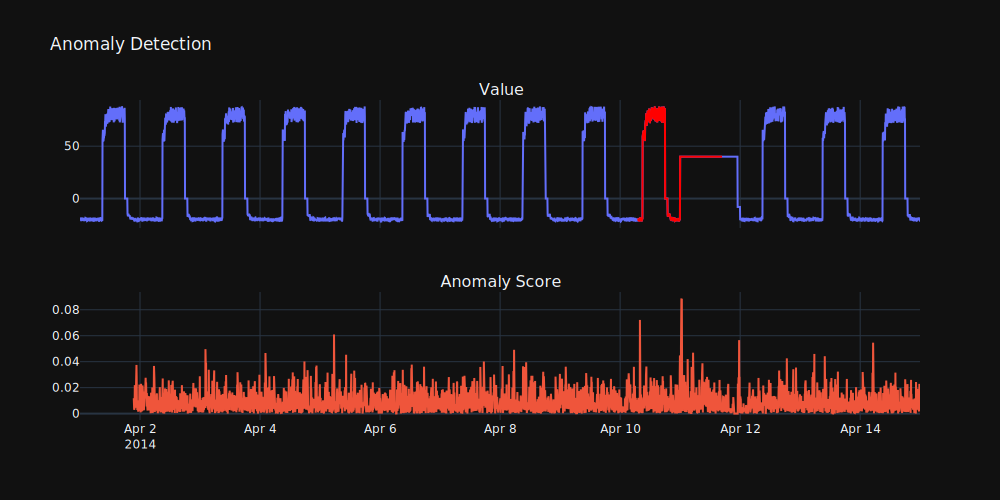

In [4]:
anomaly_detection("artificialWithAnomaly/art_daily_flatmiddle.csv", irritate=False)


Epoch [1/10], Loss: 2.2440
Epoch [2/10], Loss: 1.9985
Epoch [3/10], Loss: 1.9238
Epoch [4/10], Loss: 1.8770
Epoch [5/10], Loss: 1.7932
Epoch [6/10], Loss: 1.6731
Epoch [7/10], Loss: 1.4937
Epoch [8/10], Loss: 1.3261
Epoch [9/10], Loss: 1.1260
Epoch [10/10], Loss: 0.9386
Epoch [1/10], Loss: 0.4246
Epoch [2/10], Loss: 0.3154
Epoch [3/10], Loss: 0.3100
Epoch [4/10], Loss: 0.2894
Epoch [5/10], Loss: 0.2951
Epoch [6/10], Loss: 0.2936
Epoch [7/10], Loss: 0.3125
Epoch [8/10], Loss: 0.3107
Epoch [9/10], Loss: 0.2901
Epoch [10/10], Loss: 0.2909


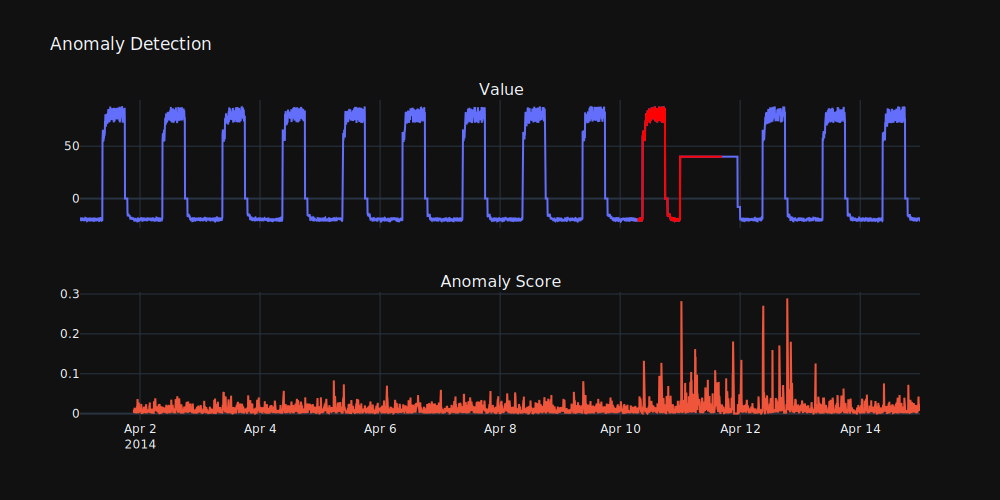

In [5]:
anomaly_detection("artificialWithAnomaly/art_daily_flatmiddle.csv", irritate=True)
# Irritating the model makes it more sensitive to anomalies

Epoch [1/10], Loss: 0.4649
Epoch [2/10], Loss: 0.4176
Epoch [3/10], Loss: 0.4087
Epoch [4/10], Loss: 0.3890
Epoch [5/10], Loss: 0.3439
Epoch [6/10], Loss: 0.2826
Epoch [7/10], Loss: 0.2279
Epoch [8/10], Loss: 0.1928
Epoch [9/10], Loss: 0.1754
Epoch [10/10], Loss: 0.1728


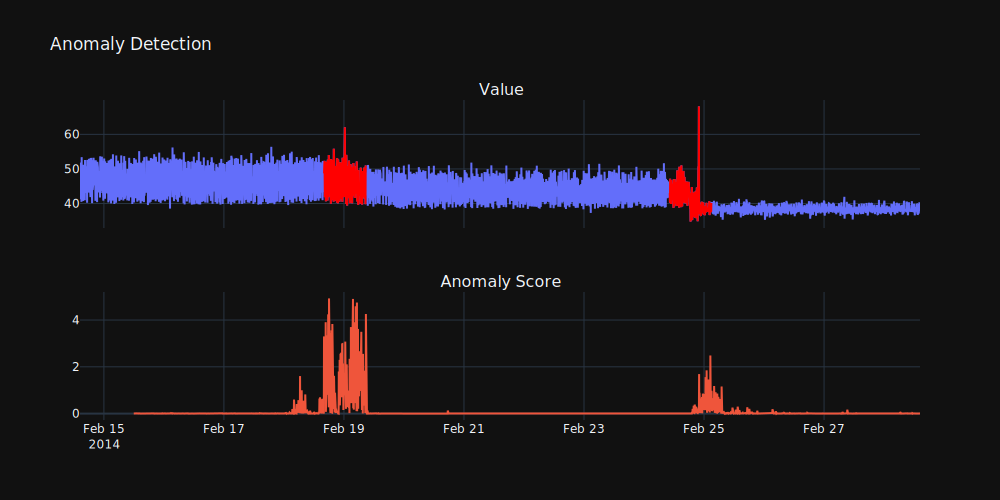

In [6]:
anomaly_detection("realAWSCloudwatch/ec2_cpu_utilization_5f5533.csv", irritate=False)

Epoch [1/10], Loss: 0.0370
Epoch [2/10], Loss: 0.0169
Epoch [3/10], Loss: 0.0187
Epoch [4/10], Loss: 0.0133
Epoch [5/10], Loss: 0.0173
Epoch [6/10], Loss: 0.0196
Epoch [7/10], Loss: 0.0167
Epoch [8/10], Loss: 0.0134
Epoch [9/10], Loss: 0.0159
Epoch [10/10], Loss: 0.0133


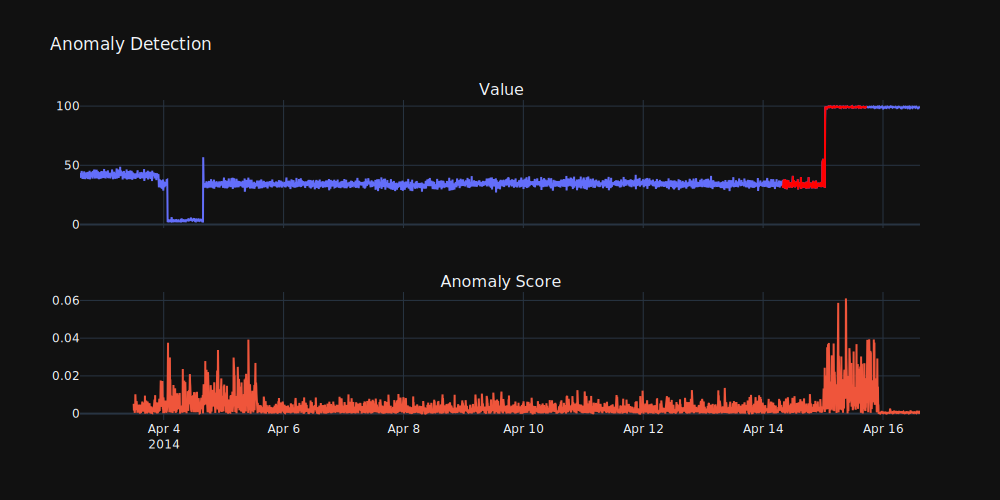

In [7]:
anomaly_detection("realAWSCloudwatch/ec2_cpu_utilization_ac20cd.csv", irritate=False)

Epoch [1/10], Loss: 1.9564
Epoch [2/10], Loss: 1.8954
Epoch [3/10], Loss: 1.8723
Epoch [4/10], Loss: 1.8189
Epoch [5/10], Loss: 1.6425
Epoch [6/10], Loss: 1.3688
Epoch [7/10], Loss: 1.1092
Epoch [8/10], Loss: 0.9267
Epoch [9/10], Loss: 0.7712
Epoch [10/10], Loss: 0.6549
Epoch [1/10], Loss: 0.1145
Epoch [2/10], Loss: 0.0209
Epoch [3/10], Loss: 0.0174
Epoch [4/10], Loss: 0.0122
Epoch [5/10], Loss: 0.0129
Epoch [6/10], Loss: 0.0152
Epoch [7/10], Loss: 0.0163
Epoch [8/10], Loss: 0.0169
Epoch [9/10], Loss: 0.0138
Epoch [10/10], Loss: 0.0182


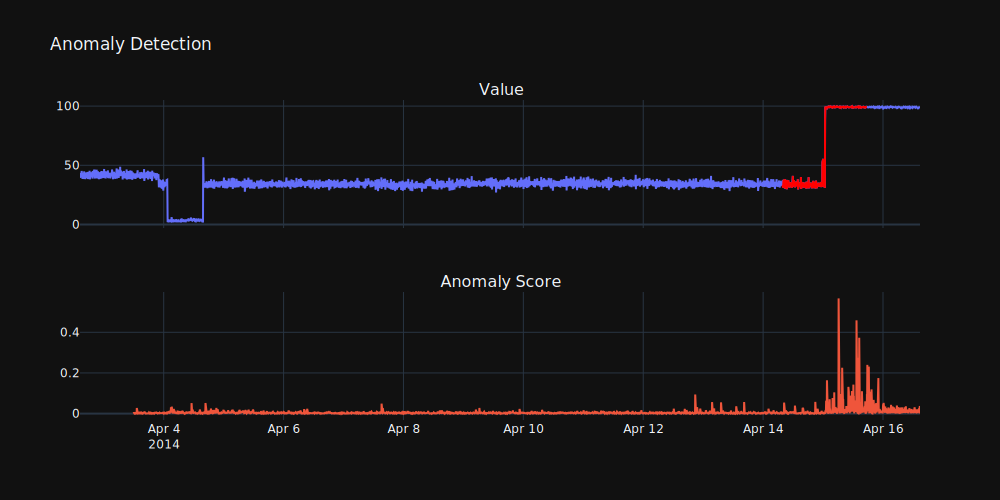

In [8]:
anomaly_detection("realAWSCloudwatch/ec2_cpu_utilization_ac20cd.csv", irritate=True)

Epoch [1/10], Loss: 0.6295
Epoch [2/10], Loss: 0.5307
Epoch [3/10], Loss: 0.4627
Epoch [4/10], Loss: 0.4253
Epoch [5/10], Loss: 0.3977
Epoch [6/10], Loss: 0.3565
Epoch [7/10], Loss: 0.3242
Epoch [8/10], Loss: 0.2841
Epoch [9/10], Loss: 0.2493
Epoch [10/10], Loss: 0.2334


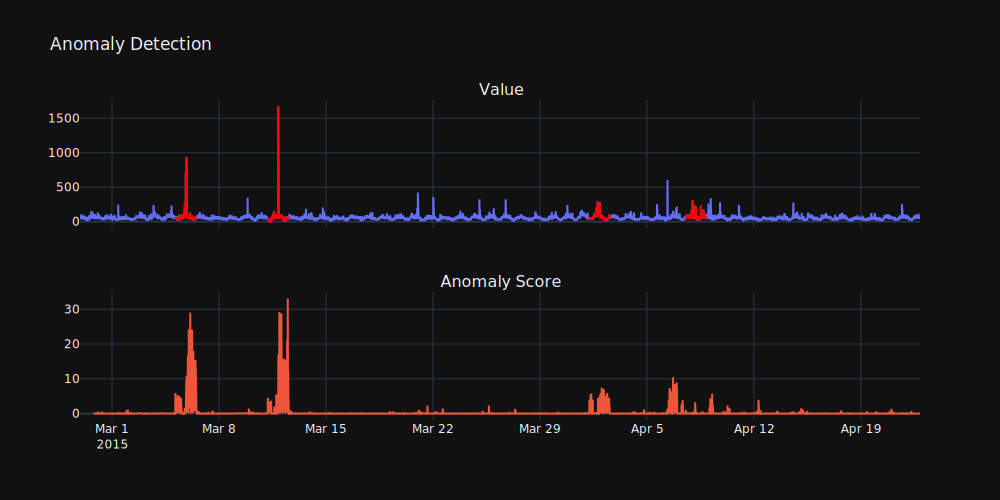

In [9]:
anomaly_detection("realTweets/Twitter_volume_AMZN.csv")